In [206]:
import pyabc
import fitmulticell as fmc
import scipy as sp
import numpy as np
import pandas as pd
import os
import tempfile
import matplotlib.pyplot as plt

In [243]:
A4_SIZE = (11.69, 8.27)

In [40]:
def gettempdir():
    return os.path.join(os.getenv('HOME'), '_tmp', 'morpheus/')

if not os.path.exists(gettempdir()):
    os.makedirs(gettempdir())

In [237]:
MORPHEUS_BIN = '/usr/local/bin/morpheus'

def get_morpheus_model(model_xml, model_par_map, sumstat_funs=None):
    return fmc.model.MorpheusModel(
        model_xml,
        par_map=model_par_map,
        sumstat_funs=sumstat_funs,
        executable=MORPHEUS_BIN,
        show_stdout=False,
        show_stderr=True,
        raise_on_error=False,
        prefix=gettempdir()
    )

In [43]:
class LogParser(fmc.sumstat.base.SumstatFun):
    def __init__(self, log_file, name):
        super().__init__(name)
        self._log_file = log_file

    def __call__(self, loc: str):
        df = fmc.util.tsv_to_df(loc, self._log_file)
        dct = df.to_dict(orient='list')
        for key, val in dct.items():
            dct[key] = np.array(val)
        return dct

## Dpp Morphogen

In [238]:
model_xml = 'Dpp-morphogen.xml'  # Specify XML path
db_path = 'sqlite:///' + gettempdir() + '/' + model_xml + '.db'
param_key = 'lbd'
par_map = {
    param_key: './CellTypes/CellType[@name=\'cells\']/Constant[@symbol=\'lbd\']'
}  # Create parameter mapping
true_par = {
  param_key: 0.01
}  # True parameter
true_par_limits = {
  param_key: (0.5 * true_par[param_key], 2 * true_par[param_key])
}  # Bounds for true parameter
base_parser = 'test'
time_key = base_parser + '2__time'
measurement_key = base_parser + '2__aspect'
log_parsers = [
    LogParser('logger_1.csv', base_parser + '1'),
    LogParser('logger_2.csv', base_parser + '2')
]  # log parsers

def get_time_ref(data):
    return data[time_key]

def get_measurements(data):
    return data[measurement_key]

In [245]:
model_prior = pyabc.Distribution(
    **{key: pyabc.RV("uniform", lb, ub - lb) for key, (lb, ub) in true_par_limits.items()}
)  # Set prior for parameters

def l1_norm(x, y):
    abs_diff = np.absolute(x - y)
    return abs_diff.sum()

def distance(data, simulation):
    return np.absolute(data['last_aspect'] - simulation['last_aspect'])

def sumstat(data):
    last_measurement = data[measurement_key][-1]

    return {
        'last_aspect': last_measurement
    }

abc = pyabc.ABCSMC(
    models=model,
    parameter_priors=model_prior,
    distance_function=distance,
    summary_statistics=sumstat
)

data_pruned = {
    'last_aspect': 1.5
}
abc.new(db_path, data_pruned)

INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=33, start_time=2020-07-04 21:45:15.291836, end_time=None)>


In [235]:
model = get_morpheus_model(model_xml, par_map, sumstat_funs=log_parsers)
data = model.sample(true_par)  # generate observed data sampled from true parameters

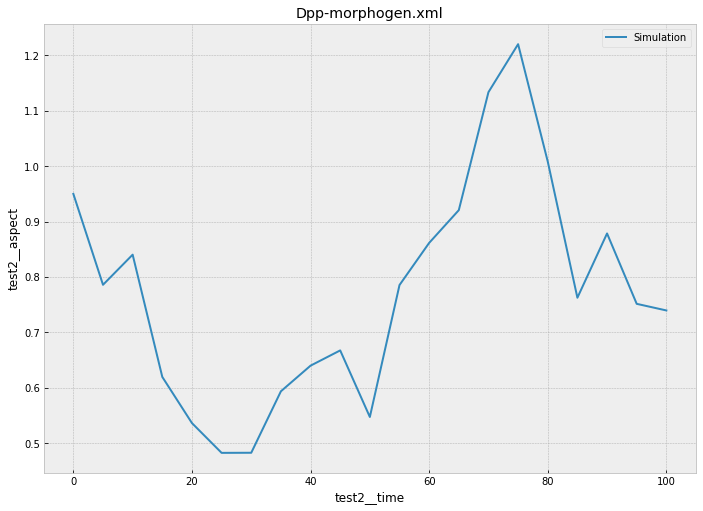

In [244]:
time_measurements = get_time_ref(data)
measurements = get_measurements(data)

plt.gcf().set_size_inches(*A4_SIZE, forward=True)
plt.plot(
    time_measurements,
    measurements,
    label='Simulation'
)

# prettify
plt.xlabel(time_key)
plt.ylabel(measurement_key)
plt.title(model_xml)
plt.legend()
plt.show()

INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=32, start_time=2020-07-04 16:43:51.374987, end_time=None)>


In [231]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=10)

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.4970156181999997
INFO:ABC:t: 0, eps: 0.4970156181999997.
INFO:ABC:Acceptance rate: 100 / 207 = 4.8309e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.29817822699999996.
INFO:ABC:Acceptance rate: 100 / 457 = 2.1882e-01, ESS=9.6708e+01.
INFO:ABC:t: 2, eps: 0.15659778513396289.
INFO:ABC:Acceptance rate: 100 / 1256 = 7.9618e-02, ESS=9.6691e+01.
INFO:ABC:t: 3, eps: 0.08835531192655283.
INFO:ABC:Acceptance rate: 100 / 2378 = 4.2052e-02, ESS=9.0170e+01.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=32, start_time=2020-07-04 16:43:51.374987, end_time=2020-07-04 18:59:49.320967)>


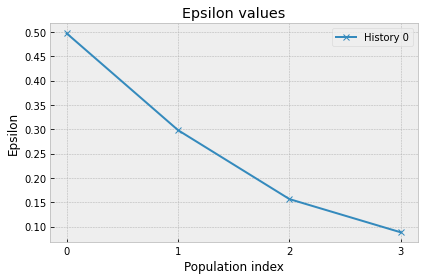

In [232]:
pyabc.visualization.plot_epsilons(history)  # Epsilon vs. Population
plt.show()

# pyabc.visualization.plot_kde_matrix_highlevel(history, refval=true_par)
# plt.show()

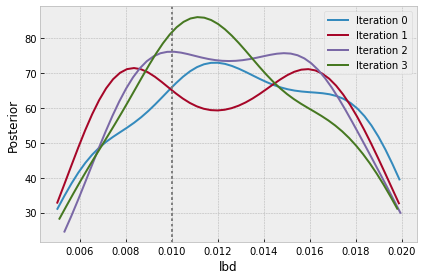

In [233]:
fig, ax = plt.subplots()

for t in range(history.max_t + 1):
    label = 'Iteration {}'.format(t)
    pyabc.visualization.plot_kde_1d_highlevel(
        history, x=param_key, t=t, refval=true_par, refval_color='grey', ax=ax, label=label
    )

ax.legend()
fig.tight_layout()
plt.show()

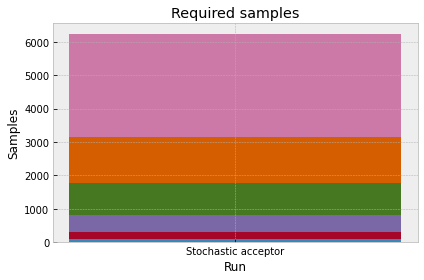

In [224]:
pyabc.visualization.plot_sample_numbers([history], ['Stochastic acceptor'])
plt.show()